# CS 224, Winter 2021
## Problem Set 3

## Due February 28, 2021 @ 11:59pm PST


<div class="alert alert-info">
    <b>Complete with your Information</b><br>
    <i>By Submitting this notebook, I assert that all of the work presented here is my own and performed for the express sole purpose of this offering of this course.</i><br>
        <br>
      <b>(full) Name:</b>  Sakshar Chakravarty  <br>
    <b>Student ID Number:</b> 862253039
</div>

<div class="alert alert-success">
    <font size=+2>Total Problem Set Grading</font> (to be completed by grader)<br>
    Total Points: 23.5/24<br>
    Late Days Used on this assignment: 0<br>
    Total Late Days Used: 0<br>
    Excellent
</div>

## Preliminaries

We will again (for the last time) be using the data shown in class on house sales in Ames, Iowa.  Data documentation can be found at http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

This code is just as PS 2, **EXCEPT** that the features have been standardized and then down-selected to 50 features using PCA.  **AND**, the prediction is now whether the price will is $\ge\$200,000$ ($y=1$) or not ($y=0$).

The code block below again loads in the data, does the PCA and thresholds the $y$-values.

**Do NOT adjust** this code.  Further, you **may not add additional imports** to this notebook.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100 # this and above will make the figures large enough to read
def loadamesdata(trainfrac = 0.5):
    import pandas as pd
    from IPython.display import display
    
    dataframe = pd.read_table('AmesHousing.txt',delimiter='\t')

    dataframe = dataframe[dataframe['Gr Liv Area']<4000] # remove the five really large houses
    dataframe = dataframe[dataframe['Sale Condition']=='Normal'] # don't consider partial sales or other types of abnormal sales
    dataframe = dataframe.drop(columns=['Order','PID','Sale Condition'])
    
    categoricalf = [col for col in dataframe if dataframe[col].dtype.name=='object' or col=='MS SubClass']
     # Here we are encoding the categorical variables using a "one-hot" encoding.  A variable with 3 values (A, B, C)
    # gets converted into three binary variables.  For any example (row) exactly one of these binary variables is 1
    # indicating which value the original categorical variable took on.
    dataframe = pd.get_dummies(dataframe,columns=categoricalf,prefix=categoricalf,dummy_na=True)
    # Here we are going to remove any item that is missing a value (encoded as NaN at this stage)
    # This is slightly problematic (it could be the missingness is actually related to the value or other features' values)
    # Filling it in (with say the average for that feature) is also problematic, in different ways
    # So for this problem set, we'll just remove listings (rows) that are missing any of their non-categorical features
    dataframe.dropna(inplace=True) # 
    
    dataframe = dataframe.loc[:,(dataframe!=dataframe.iloc[0]).any()] # drop features that have all the same value (across both training and testing)
    
    dataframe['SalePrice'] = dataframe['SalePrice']/1000 # convert to thousands of dollars, to prevent lots of extra 0s from needing to be printed
    dataframe = dataframe[[c for c in dataframe if c != 'SalePrice']+['SalePrice']]# rearrange to put SalePrice at the end:
    # training/testing split
    # can use "from sklearn.model_selection import train_test_split"
    # but to more directly show what is going on, here is a more "raw" version:
    allXY = dataframe.to_numpy()
    

    allXY = allXY[np.isfinite(allXY).all(axis=1),:]
    
    # in general, we would take a random shuffle.  However, to grade this consistently, I am going to fix the randomness of the shuffle
    np.random.seed(8293781) # my favorite number (well, out of the natural numbers) ;)
    np.random.shuffle(allXY) # randomly shuffles the *rows* of the input (or along whatever is the first dimension of the tensor)
    # we'll pick the first 50% (as default -- see "trainfrac" parameter as training and save the last 50% for testing
    lasttraini = int(allXY.shape[0]*trainfrac)
    trainXY = allXY[:lasttraini,:]
    testXY = allXY[lasttraini:,:]
    
    trainX = trainXY[:,:-1]
    trainY = trainXY[:,-1]
    testX = testXY[:,:-1]
    testY = testXY[:,-1]

    return trainX,trainY,testX,testY, dataframe.columns

trainX,trainY,testX,testY,featurenames = loadamesdata(0.75)

# use PCA to get to 50 features
nfeat = 50
stdX = trainX.std(axis=0)
stdX[stdX==0.0] = 1.0
muX = trainX.mean(axis=0)
trainX = (trainX-muX)/stdX
testX = (testX-muX)/stdX
U,D,Vt = np.linalg.svd(trainX)
Vtransform = Vt.T[:,:nfeat]
trainX = trainX@Vtransform
testX = testX@Vtransform

# turn to binary decision problem:
salethreshold = 200 # ie, $200,000
trainY = (trainY>=salethreshold).astype(int)
testY = (testY>=salethreshold).astype(int)


## Problem Set Overview

This problem set explores lienar classification (particularly using Linear Discriminant Analysis and Logistic Regression), coupled with regularization and cross-validation.

In question 1, you will build the LDA and Logistic Regression learning and prediction methods.

In question 2, you will explore the effects of regularization (without using cross-validation -- by "cheating" and looking at the testing set preformance; just pretend the test set is the validation set if this bothers you :) ).

In question 3, you will implement cross-validation.

**NOTE: for all questions, your linear function should include an intercept term**

## Question 1

#### 10 points

Implementing LDA and Logistic Regression

Note that this question contains no checks or test cases; you will need to write your own to check to see that your code is correct.  This is an important skill -- how to check and debug numeric algorithms.  You might try constructing some simple inputs (small, perhaps 2d dataset) where you know the answer.


### Question 1a
### 4 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 4/4<br>
    passed
</div>

### Implement Linear Disciminant Analysis (LDA)

Implement a function that returns the weight vector for LDA

In [8]:
# X is m-by-n, Y is of size m and has values of either 0 or 1
# returns LDA weight vector of size n+1
# If w is the returned value and x is a new example,
# w^T x > 0 indicates a prediction of y=1
# and w^T x < 0 indicates a prediction of y=0
def fitlda(X,Y,redow0=False):
    plusX, minusX = X[np.where(Y==1)], X[np.where(Y==0)]
    piplus, piminus = plusX.shape[0]/X.shape[0], minusX.shape[0]/X.shape[0]
    muplus, muminus = np.sum(plusX, axis=0)/plusX.shape[0], np.sum(minusX, axis=0)/minusX.shape[0]
    diffplus, diffminus = plusX - muplus, minusX - muminus
    diff = diffplus.T@diffplus + diffminus.T@diffminus
    cov = diff/X.shape[0]
    invcov = np.linalg.inv(cov)
    w = invcov@(muplus-muminus).T
    k = np.log(piplus/piminus) - 0.5*muplus@invcov@muplus.T + 0.5*muminus@invcov@muminus.T
    w = np.insert(w, 0, k)
    return w

### Question 1b
### 6 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 6/6<br>
    passed
</div>

### Implement Logistic Regression

Implement a function that returns the weight vector for logistic regression.

Use gradient descent (not Newton's method).  For a good starting point, use the answer from LDA (which is relatively quick). 

To get quick(ish) convergence without too much fiddling, implement the following method for selecting the step-size, $\eta$:
 - Start $\eta$ at 1.0
 - If any step of gradient descent does not improve the loss function by at least $10^{-6}$:
   - undo the step
   - divide $\eta$ by 2
   - continue with gradient descent
 - Stop when $\eta$ is less than $10^{-6}$
 
Finally, once you have that working, add regularization: either $L_2$ (adding $\lambda w^\top w$) or $L_1$ (adding $\lambda |w|_1$).  You'll need to work out the correct gradients for these updates.

Note: this is not the best way to minimize with an $L_1$ regularizer, but it will be sufficient for this assignment.

In [9]:
def sigmoid(z):
    return 1.0/(1+np.exp(-z))

In [10]:
# X is m-by-n, Y is of size m and has values either 0 or 1
# lam is the strength of regularization (scalar)
# isL1 is a Boolean (True means L1 regularization, False means L2 regularization)
# returns n+1 sized weight vector for (regularized) logistic regression
def fitlogreg(X,Y,lam, isL1=False):
    ## YOUR CODE HERE (you may ignore lam and isL1 when first implementing)
    ## Feel free to add other functions or subfunctions
    weight = fitlda(X, Y)
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    eta = 1.0
    print(weight.shape,X.shape)
    predY = sigmoid(X@weight.T)
    prevloss = 0.0
    if isL1:
        prevloss = lam*np.sum(np.abs(weight))
    else:
        prevloss = lam*np.dot(weight, weight)
    for i in range(X.shape[0]):
        if Y[i] == 1:
            prevloss -= Y[i]*np.log(predY[i])
        else:
            prevloss -= (1-Y[i])*np.log(1-predY[i])
    while eta >= 0.000001:
        predY = sigmoid(X@weight.T)
        #predY = np.zeros(Y.shape)
        #for i in range(Y.shape[0]):
        #    predY[i] = sigmoid(np.dot(X[i],weight))
        g = np.sum((predY - Y).reshape((X.shape[0],1))*X, axis=0)
        #g = np.zeros(weight.shape)
        #for i in range(Y.shape[0]):
        #    g += (predY[i]-Y[i])*X[i]
        if isL1:
            dw = np.where(weight>0, 1, weight)
            dw = np.where(dw<0, -1, dw)
            g += lam*dw
        else:
            g += 2*lam*weight
        weight = weight - eta*g
        predY = sigmoid(X@weight.T)
        #for i in range(Y.shape[0]):
        #    predY[i] = sigmoid(np.dot(X[i],weight))
        loss = 0.0
        if isL1:
            loss = lam*np.sum(np.abs(weight))
        else:
            loss = lam*np.dot(weight, weight)
        for i in range(X.shape[0]):
            if Y[i] == 1:
                loss -= Y[i]*np.log(predY[i])
            else:
                loss -= (1-Y[i])*np.log(1-predY[i])
        #loss -= np.sum(Y*np.log(predY) + (1-Y)*np.log(1-predY))
        if prevloss - loss < 0.000001:
            weight = weight + eta*g
            eta = eta/2
        else:
            prevloss = loss
    return weight

## Question 2
#### 7 points

We will now look at the relationship among the regularization strength, the amount of data, and the error rate.

### Question 2a
### 3 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 3/3<br>
</div>

Plot the **testing** error rate as a function of the amount of data in the training set.  In particular, if you are looking at using $200$ training points, use the *first* 200 points in the training set.  In practice, we might want to consider shuffling the points and doing this a few times, but to keep the grading simple (and not introduce other sources of differences), just do this once with the points in the training set in their provided order.

Plot this curve on a semi-log scale (see `plt.semilogx`) where the error rate is on a linear scale (vertical axis) and the number of training points is on a log scale (horizontal axis).  Pick 20 points arranged logarithmically uniformly from 100 to the total number of training points (see `np.logspace`).

Plot this curve for 5 different $\lambda$ values for $L_2$ regularization: regularization0.01, 0.1, 1.0, 10, 100.  Also plot this for LDA.  All curves should be on the same set of axes. Use a legend to label all plots.  Label the axes.

*note:* this might take some time (my solutions take about 4 minutes)

In [11]:
### YOUR CODE HERE
def gettesterror(X, Y, w, isLDA=False):
    if isLDA:
        predY = np.hstack([np.ones((X.shape[0], 1)), X])@w
        predY = np.where(predY > 0, 1, 0)
    else:
        predY = sigmoid(np.hstack([np.ones((X.shape[0], 1)), X])@w)
        predY = np.where(predY > 0.5, 1, 0)
    return np.sum(np.abs(predY-Y))/Y.shape[0]

In [12]:
pts = 20
notrainsamples = np.logspace(2,np.log10(trainX.shape[0]),num=pts,dtype=int)
errorslogreg = np.zeros((5, pts))
errorslda = np.zeros((pts,))
lams = [0.01, 0.1, 1.0, 10, 100]

In [13]:
for i in range(pts):
    X, Y = trainX[:notrainsamples[i]], trainY[:notrainsamples[i]]
    wlda = fitlda(X, Y)
    errorslda[i] = gettesterror(testX, testY, wlda, isLDA=True)
    #print("samples:", notrainsamples[i], "ldaerror:", errorslda[i])
    for j in range(5):
        w = fitlogreg(X, Y, lams[j])
        errorslogreg[j][i] = gettesterror(testX, testY, w)
        #print("lam:", lams[j],"logregerror:", errorslogreg[j][i])

(51,) (100, 51)


C:\Users\EndUser\AppData\Local\Temp/ipykernel_18988/282471875.py:51: RuntimeWarning: divide by zero encountered in log
  loss -= (1-Y[i])*np.log(1-predY[i])


(51,) (100, 51)
(51,) (100, 51)
(51,) (100, 51)
(51,) (100, 51)
(51,) (114, 51)


C:\Users\EndUser\AppData\Local\Temp/ipykernel_18988/3813775231.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0/(1+np.exp(-z))
C:\Users\EndUser\AppData\Local\Temp/ipykernel_18988/282471875.py:49: RuntimeWarning: divide by zero encountered in log
  loss -= Y[i]*np.log(predY[i])


(51,) (114, 51)
(51,) (114, 51)
(51,) (114, 51)
(51,) (114, 51)
(51,) (131, 51)
(51,) (131, 51)
(51,) (131, 51)
(51,) (131, 51)
(51,) (131, 51)
(51,) (151, 51)
(51,) (151, 51)
(51,) (151, 51)
(51,) (151, 51)
(51,) (151, 51)
(51,) (173, 51)
(51,) (173, 51)
(51,) (173, 51)
(51,) (173, 51)
(51,) (173, 51)
(51,) (199, 51)
(51,) (199, 51)
(51,) (199, 51)
(51,) (199, 51)
(51,) (199, 51)
(51,) (229, 51)
(51,) (229, 51)
(51,) (229, 51)
(51,) (229, 51)
(51,) (229, 51)
(51,) (263, 51)
(51,) (263, 51)
(51,) (263, 51)
(51,) (263, 51)
(51,) (263, 51)
(51,) (302, 51)
(51,) (302, 51)
(51,) (302, 51)
(51,) (302, 51)
(51,) (302, 51)
(51,) (347, 51)
(51,) (347, 51)
(51,) (347, 51)
(51,) (347, 51)
(51,) (347, 51)
(51,) (398, 51)
(51,) (398, 51)
(51,) (398, 51)
(51,) (398, 51)
(51,) (398, 51)
(51,) (457, 51)
(51,) (457, 51)
(51,) (457, 51)
(51,) (457, 51)
(51,) (457, 51)
(51,) (525, 51)
(51,) (525, 51)
(51,) (525, 51)
(51,) (525, 51)
(51,) (525, 51)
(51,) (603, 51)
(51,) (603, 51)
(51,) (603, 51)
(51,) (6

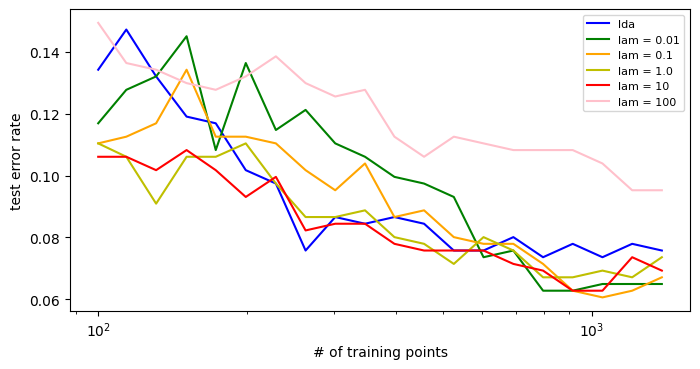

In [9]:
plt.xlabel('# of training points')
plt.ylabel('test error rate')
plt.semilogx(notrainsamples, errorslda, 'b', label='lda')
plt.semilogx(notrainsamples, errorslogreg[0], 'g', label='lam = 0.01')
plt.semilogx(notrainsamples, errorslogreg[1], 'orange', label='lam = 0.1')
plt.semilogx(notrainsamples, errorslogreg[2], 'y', label='lam = 1.0')
plt.semilogx(notrainsamples, errorslogreg[3], 'r', label='lam = 10')
plt.semilogx(notrainsamples, errorslogreg[4], 'pink', label='lam = 100')
plt.legend(loc='upper right', fontsize=8)
plt.show()

### Question 2b
### 2 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 2/2<br>
</div>

What are the differences between the LDA and logistic regression curve?

Explain these differences (perhaps by attributes of the data itself).

With the increase of the size of the training set, both LDA and logistic regression gradually perform better. However, the improvement in  the performance of logistic regression is much better than that of LDA except for $\lambda$ = 100. The most probable reason behind it can be that the training points of the two classes are not balanced and not distributed from two similar Gaussian. This properties of the training data hinder LDA to perform well. However, the performance of logistic regression does not depend on the distribution of the data points of different classes and with more training data, its performance gets better.

## Question 2c
### 2 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 1.5/2<br>
    But what does this say about the reduced dataset size of x-validation?
</div>

Just looking at the logistic regression curves, what does this plot tell us about the relationship between $\lambda$, the number of training points, and the error rate?

What does this imply for cross-validation?

For the same $\lambda$, we can see that the error rate has an inverse relationship with the number of training points. However, for the same number of training points, different $\lambda$'s have different error rates and not necessarily, they have a direct correlation. This implies that it is required to perform cross-validation by varying the value of $\lambda$ to pick the best one for the logistic regression model given the training points.

## Question 3
### 7 points

Now we will look at cross-validation to pick $\lambda$.

### Question 3a
### 3 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 3/3<br>
</div>

Divide the training set in half and use the first half as training and the second half as validation (this is extreme, usually the training would be a larger fraction, but for this assignment, this will be simpler).

Do cross-validation to pick $\lambda$ and whether to use $L_1$ or $L_2$ regularization.  That is, try $L_1$ regularization with a set of $\lambda$ values and $L_2$ regularization with a set of $\lambda$ values and pick the combination which does best in validation error.

Use the same $\lambda$ values for both forms of regularization: 20 points logarithmically spaces between $10^{-2}$ and $10^2$.

Plot the resulting validation error rate as a function of $\lambda$ for both $L_1$ and $L_2$ (two separate curves on the same plot).  Label your plot.

In [10]:
### YOUR CODE HERE
halftrainsamples = trainX.shape[0]//2
halftrainX, halftrainY = trainX[:halftrainsamples], trainY[:halftrainsamples]
validationX, validationY = trainX[halftrainsamples:], trainY[halftrainsamples:]

In [11]:
ls = 20
lamdas = np.logspace(-2,2,num=ls,dtype=float)
errors = np.zeros((2, pts))
w1s = []

In [16]:
for i in range(ls):
    w1 = fitlogreg(halftrainX, halftrainY, lamdas[i], True)
    w1s.append(w1)
    w2 = fitlogreg(halftrainX, halftrainY, lamdas[i])
    errors[0][i] = gettesterror(validationX, validationY, w1)
    errors[1][i] = gettesterror(validationX, validationY, w2)
    #print("lam:", lamdas[i],"l1:", errors[0][i], "l2:", errors[1][i])

(51,) (692, 51)


C:\Users\EndUser\AppData\Local\Temp/ipykernel_18960/282471875.py:51: RuntimeWarning: divide by zero encountered in log
  loss -= (1-Y[i])*np.log(1-predY[i])


(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)


C:\Users\EndUser\AppData\Local\Temp/ipykernel_18960/3813775231.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0/(1+np.exp(-z))
C:\Users\EndUser\AppData\Local\Temp/ipykernel_18960/282471875.py:49: RuntimeWarning: divide by zero encountered in log
  loss -= Y[i]*np.log(predY[i])


(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)
(51,) (692, 51)


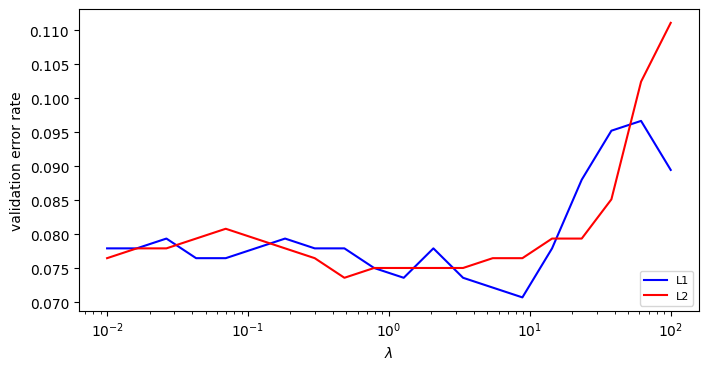

In [13]:
plt.xlabel('$\lambda$')
plt.ylabel('validation error rate')
plt.semilogx(lamdas, errors[0], 'b', label='L1')
plt.semilogx(lamdas, errors[1], 'r', label='L2')
plt.legend(loc='lower right', fontsize=8)
plt.show()

### Question 3b
### 2 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 2/2<br>
</div>

Which regularizer and with what strength does cross-validation select? Write code to print out the answer; don't do it by hand.

In [14]:
### YOUR CODE HERE
l1_min, l2_min = np.argmin(errors[0]), np.argmin(errors[1])
if errors[0][l1_min] < errors[1][l2_min]:
    print('regularizer: L1, strength:',lamdas[l1_min])
else:
    print('regularizer: L2, strength:',lamdas[l2_min])

regularizer: L1, strength: 8.858667904100823


### Question 3c
### 2 points
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: 2/2<br>
</div>

Plot the effective number of features as a function of $\lambda$ for the L1-regularizer (based on the weights learned in cross-validation, above).  

Since you are using gradient descent, your weights won't go exactly to $0$.  Count a feature as "used" if the absolute value of its weight is greater than $10^{-3}$.

Again, plot on a semi-log plot and label your plot.

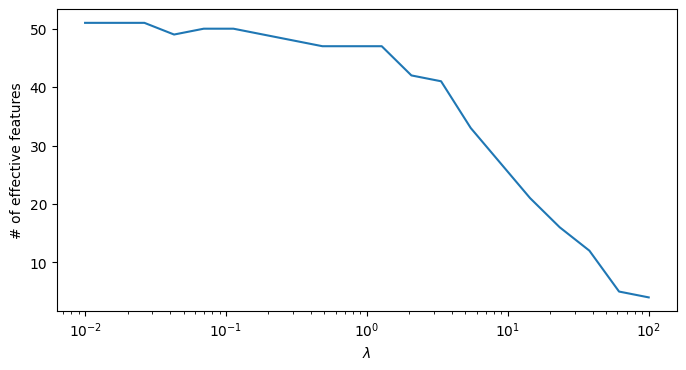

In [15]:
### YOUR CODE HERE
feats = np.zeros(lamdas.shape)
for i in range(ls):
    feats[i] = np.where(np.abs(w1s[i]) > .001)[0].shape[0]
plt.xlabel('$\lambda$')
plt.ylabel('# of effective features')
plt.semilogx(lamdas, feats)
plt.show()